# Análise Exploratória dos dados

## Resumo
Este notebook foi destinado para análise exploratória do dataset disponibilizado pelo Hospital Sírio-Libanês no [kaggle](https://www.kaggle.com/S%C3%ADrio-Libanes/covid19). A análise teve como objetivo, primeiramente, entender o dataset, pré-processar os dados de forma que seja possível usá-los como valores entrada a um algoritmo de Machine Learning, e após isso estudar proporções, correlações e variâncias com o objetivo de encontrar os possíveis caminhos ao se selecionar apenas os dados mais úteis para o problema. Por fim, os dados pré-processados foram salvos na pasta [dados_preprocessados](), a fim de serem utilizados no notebook de [Predicoes]().

## Pré-Processamento 
O pré-processamento dos dados em machine learning é um dos passos fundamentais em um projeto que se propõe a realizar predições de Machine Learning, a famosa frase "garbage in, garbage out" atribuída ao técnico da IBM George Fuechsel que significa, "entra lixo, sai lixo", demonstra muito bem o porque essa fase é tão importante, se não prepararmos os nossos dados da maneira correta os resultados podem ser mentirosos, ou não ter utilidade alguma no final, e, muitas vezes podem passar despercebidos, por esta razão essas é uma das fases mais importantes na hora de manipular dados.<br>

Uma boa parte desse processo já foi realizado pela equipe do Hospital Sírio-Libanês, de acordo com o hospital esse conjunto de dados contém dados anonimizados coletados no Hospital Sírio-Libanês, localizados em São Paulo e em Brasília. Toda a anonimização desses dados seguiu as melhores práticas e recomendações internacionais, e os dados passaram por um processo de limpeza e normalização por coluna de acordo com os valores máximos e mínimos de forma que todos os valores estivessem no intervalo entre -1 e 1.<br>
## Estrutura dos dados
### Chave primária<br>
A coluna 'PATIENT_VISIT_IDENTIFIER' é composta por números inteiros e é responsável por identificar cada paciente diferente.<br>
### Variável a ser prevista<br>
A variável a ser prevista é a coluna 'ICU', que, no conjunto de dados original, indica se o paciente correspondente estava ou não na UTI naquele momento.<br>
### Janela de tempo<br>
De acordo com o Hospital a variável 'WINDOW' diz respeito à janela de tempo onde as medições foram realizadas, ela está organizada da seguinte maneira:<br>

|Janela | Descrição|
|:-------------|:----------:|
|0-2 | Entre 0 até 2 horas a partir da admissão do paciente 
|2-4 | Entre 2 até 4 horas a partir da admissão do paciente 
|4-6 | Entre 4 até 6 horas a partir da admissão do paciente 
|6-12| Entre 6 até 12 horas a partir da admissão do paciente 
|Above-12| Mais de 12 horas horas a partir da admissão do paciente 

### Demais variáveis
As demais colunas do conjunto conjunto de dados trazem informações sobre:
* Informações demográficas do paciente (03)
* Grupos de doenças previamente identificadas pelos pacientes (09)
* Resultados de exames de sangue (36)
* Sinais vitais (06)<br>

No total são 54 variáveis, correspondente às médias, medianas, máximos, minímos, diferenças e diferenças relativas dos dados do paciente.<br>

### Dados faltantes<br>

Um dos maiores desafios ao se analisar dados médicos é a variação entre diferentes tipos de medições, por exemplo, os sinais vitais são coletados com mais frequência (geralmente de hora em hora) do que os laboratórios de sangue (geralmente diariamente).Fato esse acaba causando diversos dados faltantes uma vez que estamos analisando todos esses dados juntos em um mesmo conjunto.<br>

De acordo com o Hospital, para solucionar o problema dos dados faltantes, é razoável supor que um paciente que não tem uma medição registrada em uma janela de tempo esteja clinicamente estável, podendo apresentar sinais vitais e exames de sangue semelhantes às janelas vizinhas. Portanto, pode-se preencher os valores ausentes usando a entrada seguinte ou anterior.<br>  
### Problema a ser resolvido<br>
A identificação precoce dos pacientes que desenvolverão um curso adverso da doença (e precisam de cuidados intensivos) é a chave para um tratamento adequado (salvar vidas) e para gerenciar leitos e recursos. Um bom modelo usando apenas o primeiro (0-2) provavelmente será mais clinicamente relevante, por esta razão os dados serão agrupados de forma reorganizados a fim de agrupar os dados médicos por paciente e apenas as informações da primeira janela serão utilizadas para identificar se um paciente precisou de internação em qualquer uma das janelas.

### Escopo do projeto
- 1.0 Importação dos pacotes :<br> 
    * nesta fase foram feitas as importações das bibliotecas utilizadas no notebook
- 1.1 Importação das funções locais :
    * nesta fase foram feitas as importações das funções auxiliares criadas especificamente para o projeto que podem ser encontradas na pasta [funcoes]()
- 2 Leitura dos dados brutos
* Primeiras análises
* Análise das variáveis categóricas
* Análise de correlação das variáveis numéricas
* Análise de variância das variáveis numéricas

## Importação dos pacotes

In [53]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import re
import warnings

In [54]:
warnings.filterwarnings('ignore')
sns.set_style('darkgrid')

## Importação das funções locais

In [55]:
import os
os.chdir("../funcoes")
from feature import compute_chi2, binary_features
from my_plot import labs, annot_bar
from preprocessing import fill_exam, filter_window
os.chdir("../notebooks")

In [56]:
help(binary_features)

Help on function binary_features in module feature:

binary_features(data)



## Leitura dos dados brutos

In [152]:
df = pd.read_excel('../dados/dados_brutos/Kaggle_Sirio_Libanes_ICU_Prediction.xlsx')

## Primeiras Impressões

In [58]:
df.head()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,...,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0
2,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4-6,0
3,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,NaN,NaN,NaN,NaN,-1.000000,-1.000000,6-12,0
4,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-0.238095,-0.818182,-0.389967,0.407558,-0.230462,0.096774,-0.242282,-0.814433,ABOVE_12,1


In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1925 entries, 0 to 1924
Columns: 231 entries, PATIENT_VISIT_IDENTIFIER to ICU
dtypes: float64(225), int64(4), object(2)
memory usage: 3.4+ MB


In [60]:
df.describe()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,...,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,ICU
count,1925.000000,1925.000000,1925.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,...,1177.000000,1231.000000,1239.000000,1240.000000,1240.000000,1240.000000,1177.000000,1231.000000,1239.000000,1925.000000
mean,192.000000,0.467532,0.368831,0.108333,0.028125,0.097917,0.019792,0.128125,0.046875,0.213021,...,-0.703683,-0.770338,-0.887196,-0.786997,-0.715950,-0.817800,-0.719147,-0.771327,-0.886982,0.267532
std,111.168431,0.499074,0.482613,0.310882,0.165373,0.297279,0.139320,0.334316,0.211426,0.409549,...,0.482097,0.319001,0.296147,0.324754,0.419103,0.270217,0.446600,0.317694,0.296772,0.442787
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
25%,96.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
50%,192.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.000000,-0.976190,-0.979798,-1.000000,-0.984944,-0.989822,-1.000000,-0.975924,-0.980333,0.000000
75%,288.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.647059,-0.595238,-0.878788,-0.645482,-0.522176,-0.662529,-0.634409,-0.594677,-0.880155,1.000000
max,384.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [61]:
df.iloc[:, ~df.columns.isin(df.describe().columns)]

,AGE_PERCENTIL,WINDOW
0,60th,0-2
1,60th,2-4
2,60th,4-6
3,60th,6-12
4,60th,ABOVE_12
...,...,...
1920,50th,0-2
1921,50th,2-4
1922,50th,4-6
1923,50th,6-12


In [153]:
df = fill_exam(df)
df = filter_window(df)
df = df.dropna()
df.describe()
df = df.drop(['WINDOW', 'PATIENT_VISIT_IDENTIFIER'],axis=1)

## Análise variáveis categóricas

### Coluna "AGE_PERCENTIL"

In [12]:
percentil_prop = df.groupby('AGE_PERCENTIL')['ICU'].value_counts(normalize=True).reset_index(name='Prop')

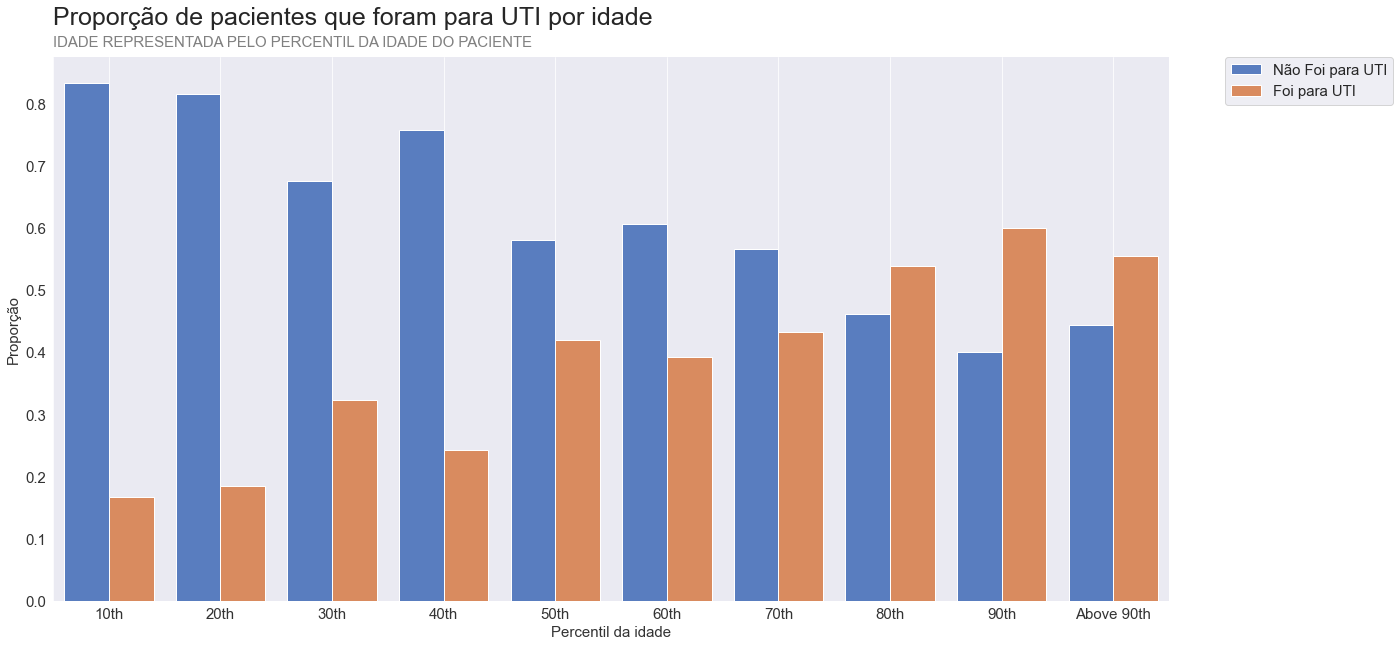

In [13]:
fig, ax = plt.subplots(figsize=(20,10)) 

sns.barplot(data=percentil_prop, y='Prop', x='AGE_PERCENTIL', hue='ICU', ax=ax, palette='muted')
labs(title='Proporção de pacientes que foram para UTI por idade', subtitle='IDADE REPRESENTADA PELO PERCENTIL DA IDADE DO PACIENTE',
     xlabel='Percentil da idade', ylabel='Proporção',ax=ax)
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[0:2], ['Não Foi para UTI', 'Foi para UTI'], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=15)
plt.show()

In [154]:
df['UNDER_30'] = [1 if row['AGE_PERCENTIL'] in ['10th', '20th'] else 0 for _,row in df.iterrows()] 
df['30th_40th'] = [1 if row['AGE_PERCENTIL'] in ['30th', '40th'] else 0 for _,row in df.iterrows()] 
df['50th_70th'] = [1 if row['AGE_PERCENTIL'] in ['50th','60th', '70th'] else 0 for _,row in df.iterrows()] 
df['ABOVE_80'] = [1 if row['AGE_PERCENTIL'] in ['80th', '90th', 'Above 90th'] else 0 for _,row in df.iterrows()] 
df.drop('AGE_PERCENTIL', axis=1, inplace=True)

In [134]:
df

,,AGE_ABOVE65,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,...,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,ICU,UNDER_30,ABOVE_30,ABOVE_50,ABOVE_80
PATIENT_VISIT_IDENTIFIER,,,,,,,,,,,,,,,,,,,,,,
0,0,1,0,0,0,0,0,1,1,0,0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1,0,1,1,0
2,10,0,0,0,0,0,0,0,0,0,0,...,-0.351328,-0.747001,-0.756272,-1.000000,-0.961262,1,1,0,0,0
3,15,0,1,0,0,0,0,0,0,0,1,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0,0,1,0,0
4,20,0,0,0,0,0,0,0,0,0,0,...,-0.883669,-0.956805,-0.870968,-0.953536,-0.980333,0,1,0,0,0
5,25,0,0,0,0,0,0,0,0,0,0,...,-0.714460,-0.986481,-1.000000,-0.975891,-0.980129,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
380,1900,0,1,0,0,0,0,0,0,0,1,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1,0,1,0,0
381,1905,1,0,0,0,0,0,0,0,0,1,...,-1.000000,-1.000000,-1.000000,-0.612627,-1.000000,0,0,0,1,1
382,1910,0,0,0,0,0,0,0,0,0,0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1,0,1,1,0


In [17]:
diseases = [col for col in binary_cols if re.match(r'DISEASE.*', col) or col=='ICU']
gender = ['GENDER', 'ICU']
above65 = ['AGE_ABOVE65', 'ICU']
others = ['HTN','IMMUNOCOMPROMISED','OTHER', 'ICU']

### Variávies binárias

In [108]:
binary = binary_features(df)
binary

['AGE_ABOVE65',
 'GENDER',
 'DISEASE GROUPING 1',
 'DISEASE GROUPING 2',
 'DISEASE GROUPING 3',
 'DISEASE GROUPING 4',
 'DISEASE GROUPING 5',
 'DISEASE GROUPING 6',
 'HTN',
 'IMMUNOCOMPROMISED',
 'OTHER',
 'ICU']

In [112]:
df[binary] = df[binary].astype('int64')
df.dtypes

AGE_ABOVE65                     int64
AGE_PERCENTIL                  object
GENDER                          int64
DISEASE GROUPING 1              int64
DISEASE GROUPING 2              int64
                               ...   
HEART_RATE_DIFF_REL           float64
RESPIRATORY_RATE_DIFF_REL     float64
TEMPERATURE_DIFF_REL          float64
OXYGEN_SATURATION_DIFF_REL    float64
ICU                             int64
Length: 229, dtype: object

### Colunas relacionadas as doenças dos pacientes

In [18]:
diseases_melt  = pd.melt(df[diseases], id_vars='ICU')
diseases_prop = diseases_melt.groupby(['variable','value'])['ICU'].mean().reset_index(name='Prop')

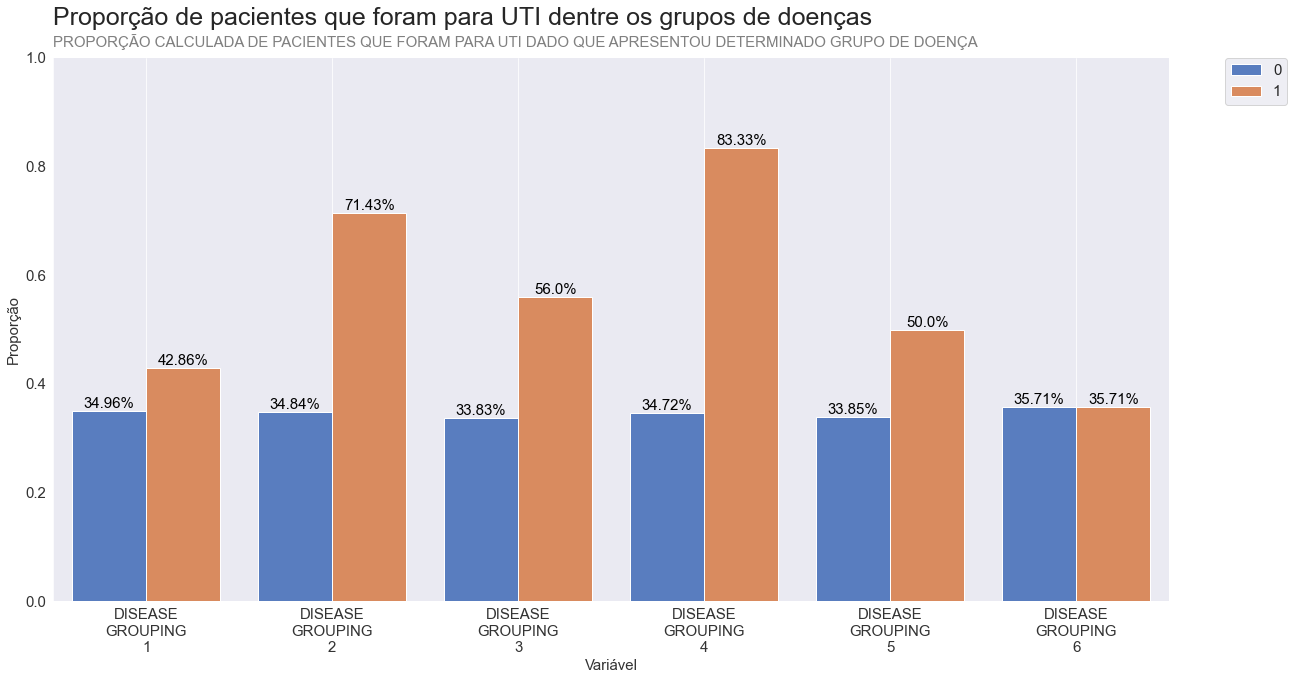

In [19]:
fig, ax = plt.subplots(figsize=(20,10)) 

sns.barplot(data=diseases_prop, y='Prop', x='variable', hue='value', ax=ax, palette='muted')
labs(title='Proporção de pacientes que foram para UTI dentre os grupos de doenças', 
     subtitle='PROPORÇÃO CALCULADA DE PACIENTES QUE FORAM PARA UTI DADO QUE APRESENTOU DETERMINADO GRUPO DE DOENÇA',
     xlabel='Variável', ylabel='Proporção',ax=ax)
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[0:2], ['0','1'], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=15)
plt.xticks(range(6),labels=diseases_prop['variable'].str.split(r'_| ').str.join('\n').unique())
annot_bar(diseases_prop, ax)
plt.ylim([0,1])
plt.show()

### Colunas relacionadas às demais condições médicas do paciente

In [22]:
others_melt  = pd.melt(df[others], id_vars='ICU')
others_prop = others_melt.groupby(['variable','value'])['ICU'].mean().reset_index(name='Prop')

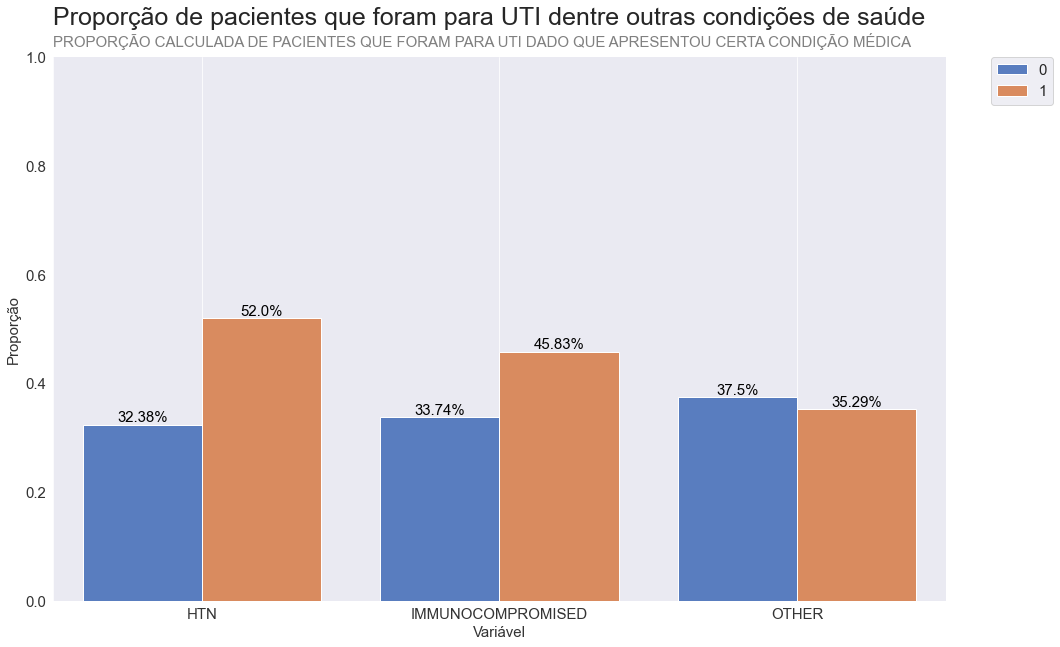

In [36]:
fig, ax = plt.subplots(figsize=(16,10)) 

sns.barplot(data=others_prop, y='Prop', x='variable', hue='value', ax=ax, palette='muted')
labs(title='Proporção de pacientes que foram para UTI dentre outras condições de saúde', 
     subtitle='PROPORÇÃO CALCULADA DE PACIENTES QUE FORAM PARA UTI DADO QUE APRESENTOU CERTA CONDIÇÃO MÉDICA',
     xlabel='Variável', ylabel='Proporção',ax=ax)
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[0:2], ['0','1'], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=15)
annot_bar(others_prop, ax)
plt.ylim([0,1])
plt.show()

### Coluna de gênero

In [24]:
gender_melt  = pd.melt(df[gender], id_vars='ICU')
gender_prop = gender_melt.groupby(['variable','value'])['ICU'].mean().reset_index(name='Prop')

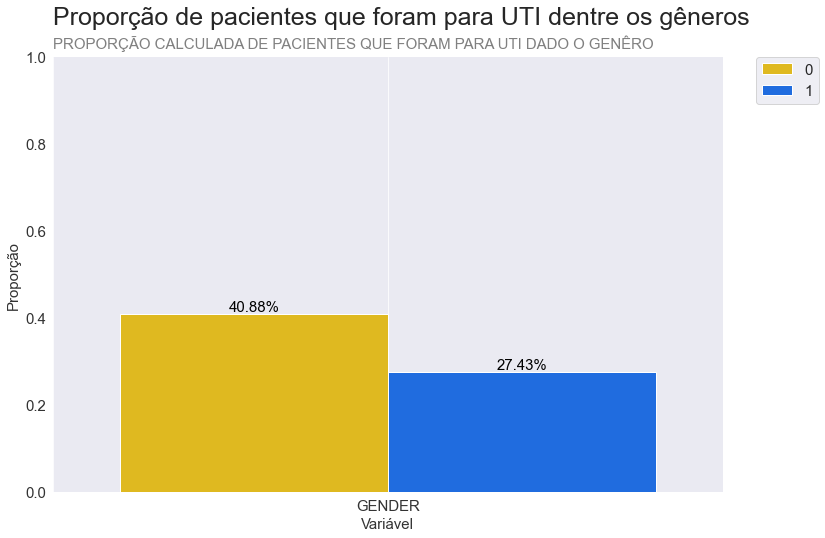

In [38]:
fig, ax = plt.subplots(figsize=(12,8)) 

sns.barplot(data=gender_prop, y='Prop', x='variable', hue='value', ax=ax, palette=['#ffcc00','#0066ff'])
labs(title='Proporção de pacientes que foram para UTI dentre os gêneros', 
     subtitle='PROPORÇÃO CALCULADA DE PACIENTES QUE FORAM PARA UTI DADO O GENÊRO',
     xlabel='Variável', ylabel='Proporção',ax=ax)
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[0:2], ['0','1'], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=15)
annot_bar(gender_prop, ax)
plt.ylim([0,1])
plt.show()

### Coluna "AGE_ABOVE65"

In [26]:
above65_melt  = pd.melt(df[above65], id_vars='ICU')
above65_prop = above65_melt.groupby(['variable','value'])['ICU'].mean().reset_index(name='Prop')

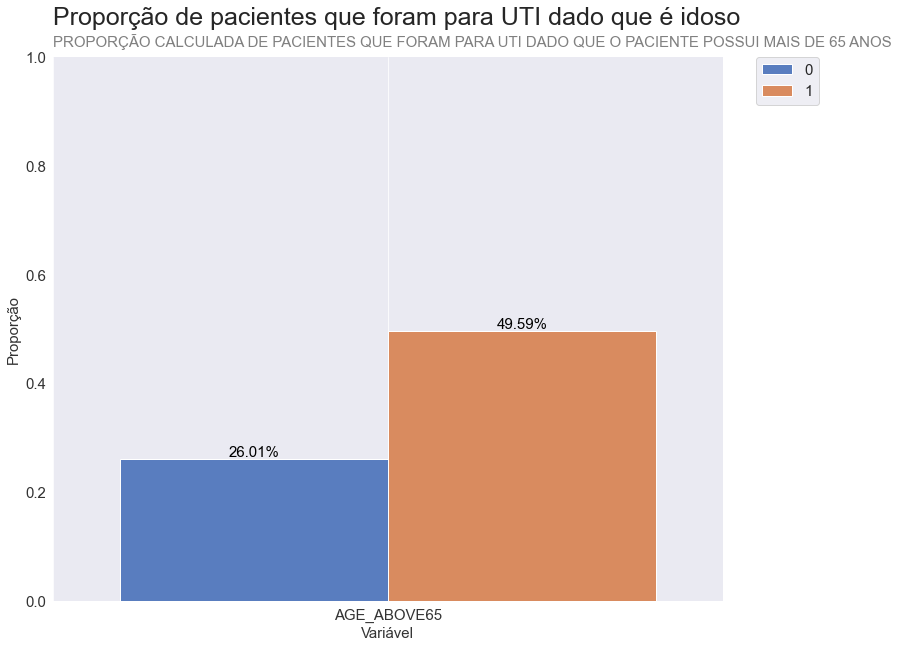

In [37]:
fig, ax = plt.subplots(figsize=(12,10)) 

sns.barplot(data=above65_prop, y='Prop', x='variable', hue='value', ax=ax, palette='muted')
labs(title='Proporção de pacientes que foram para UTI dado que é idoso', 
     subtitle='PROPORÇÃO CALCULADA DE PACIENTES QUE FORAM PARA UTI DADO QUE O PACIENTE POSSUI MAIS DE 65 ANOS',
     xlabel='Variável', ylabel='Proporção',ax=ax)
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[0:2], ['0','1'], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=15)
annot_bar(above65_prop, ax)
plt.ylim([0,1])
plt.show()

### Teste de Chi2

## Análise de correção entre as variáveis

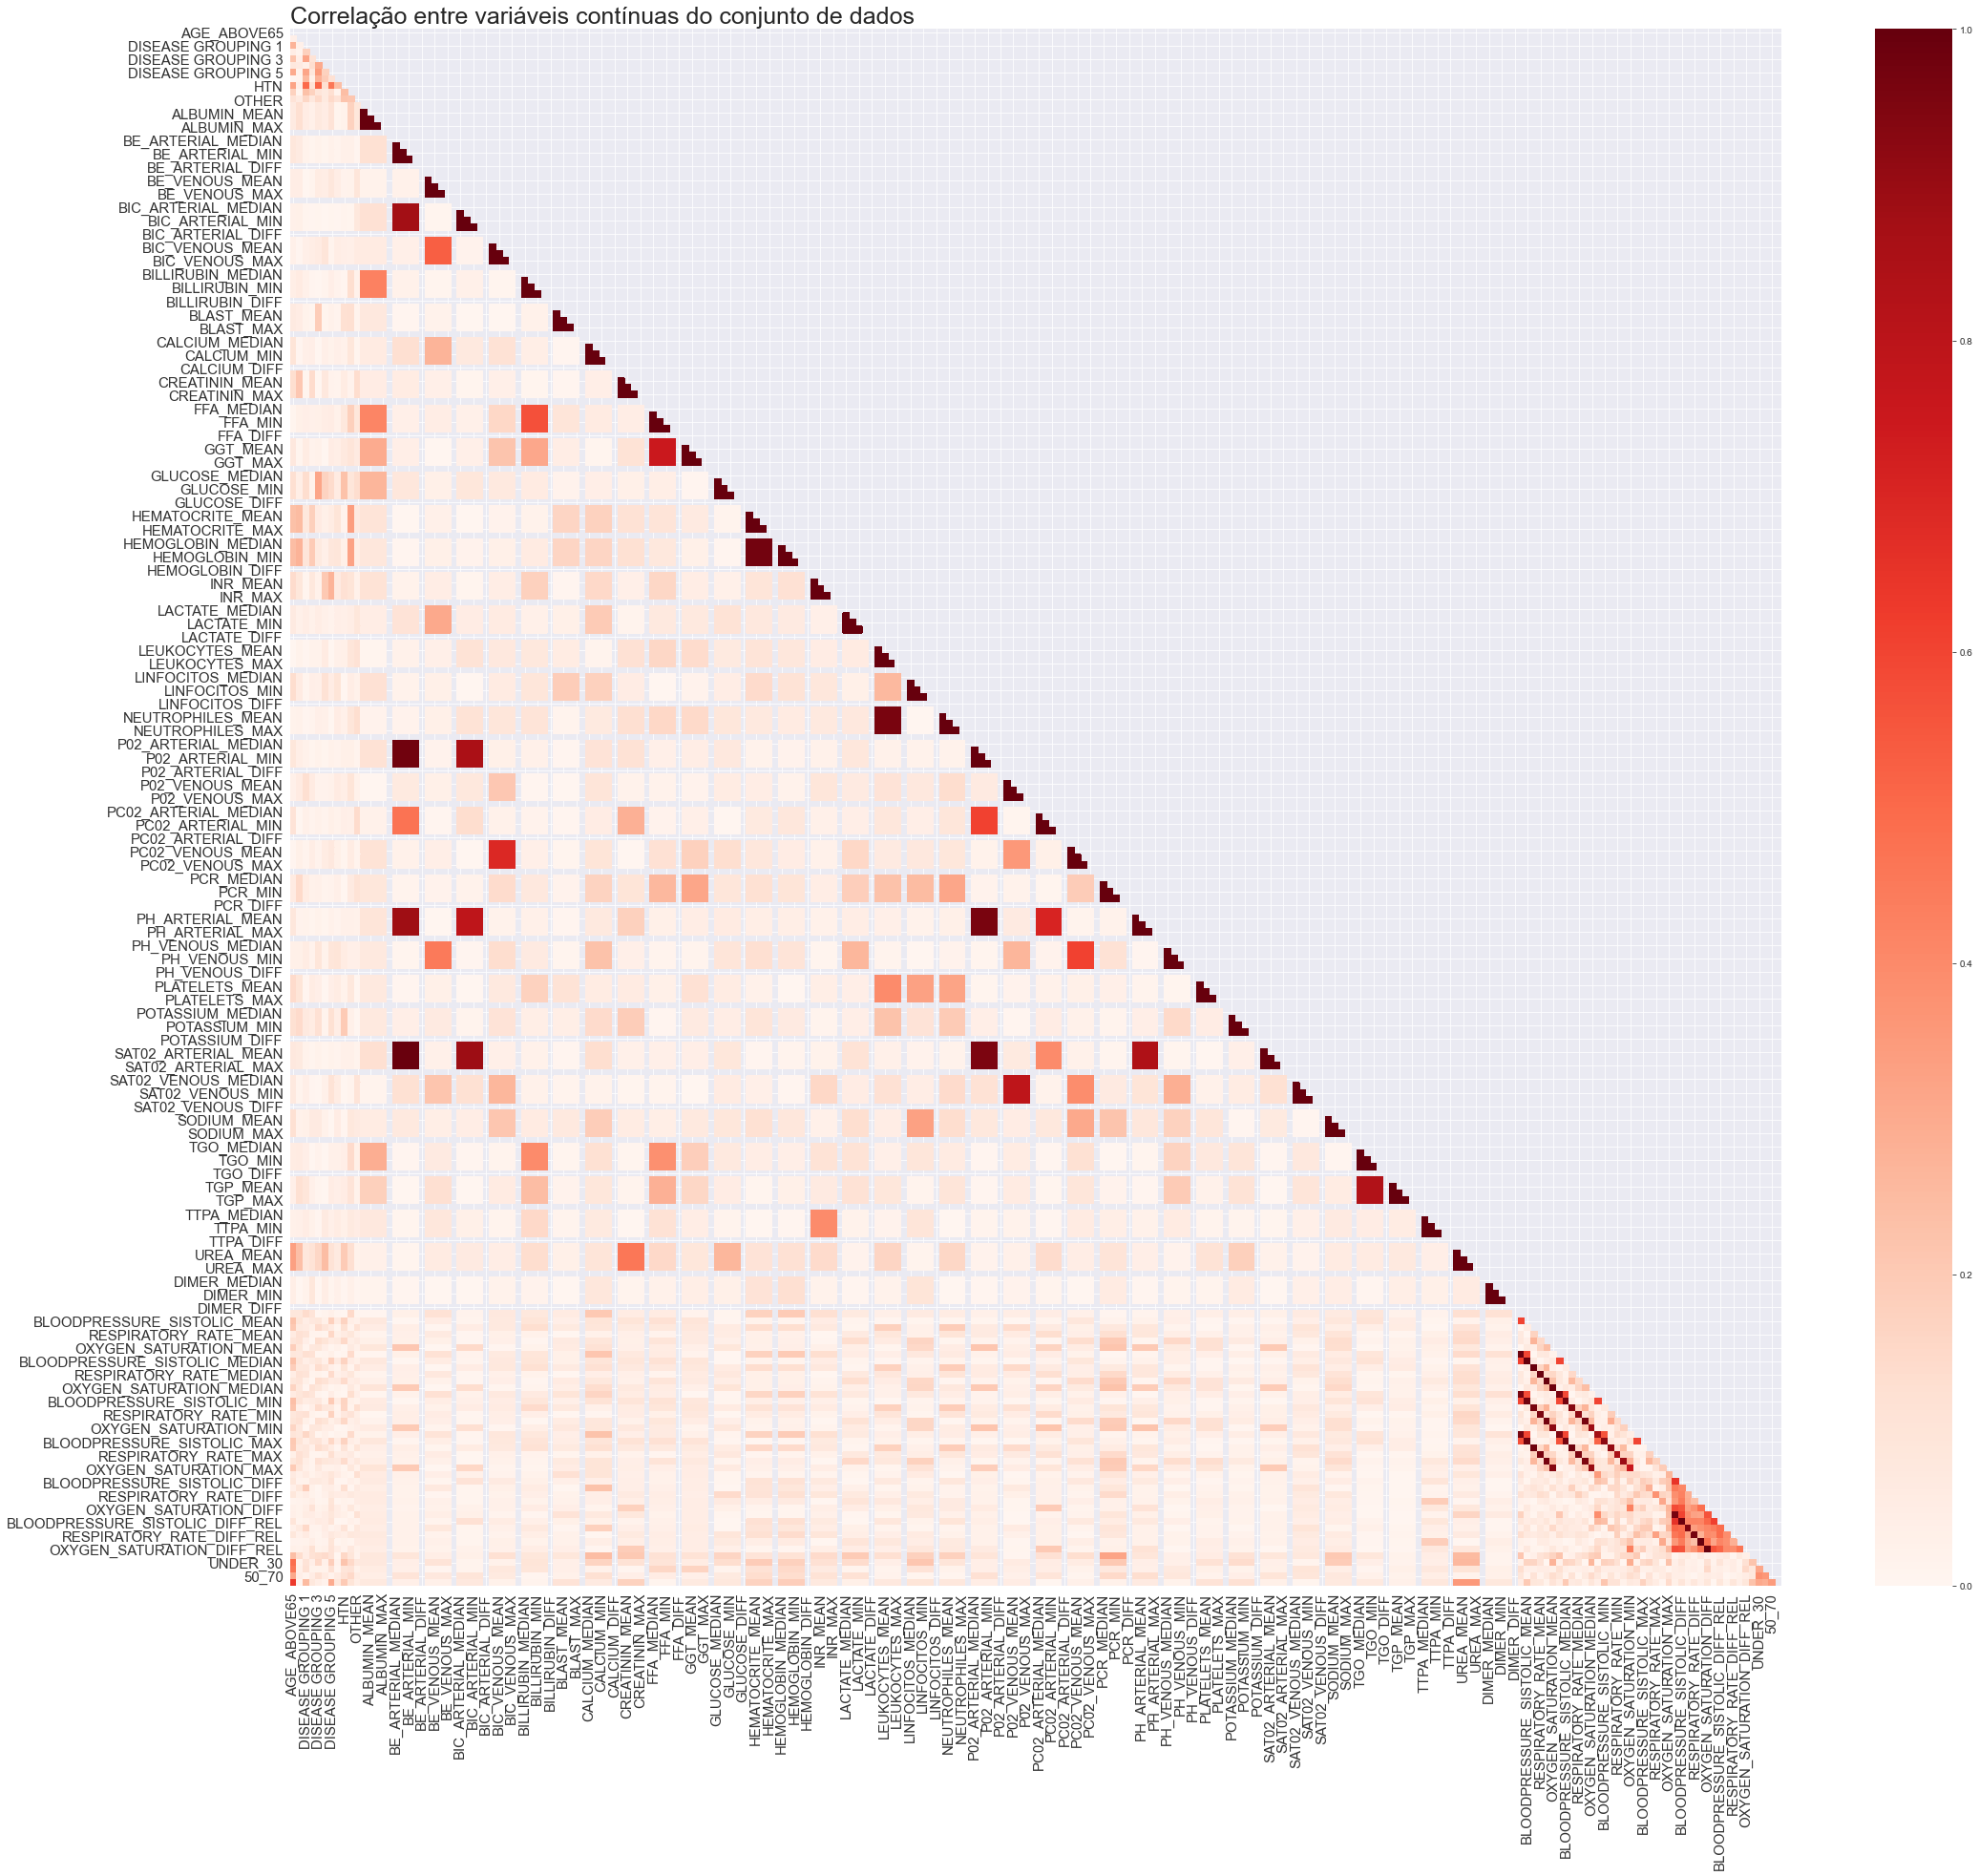

In [40]:
fig,ax = plt.subplots(figsize=(35, 30))
cor = df.corr().abs()
mask = np.triu(np.ones_like(cor, dtype=bool))
sns.heatmap(cor,
            cmap='Reds',
            mask=mask,
            ax=ax)
labs(title='Correlação entre variáveis contínuas do conjunto de dados', ax=ax)
plt.show()

In [143]:
matrix_corr_upper = cor.where(np.triu(np.ones(cor.shape), k=1).astype(np.bool)).abs()

<AxesSubplot:>

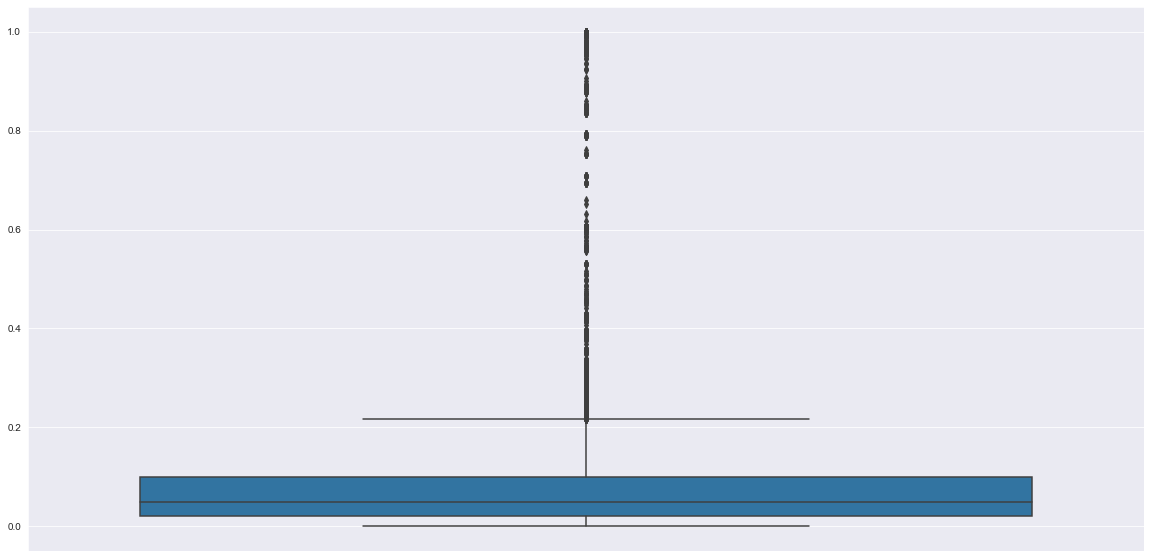

In [148]:
fig, ax = plt.subplots(figsize=(20,10))
sns.boxplot(y=matrix_corr_upper.values)

### Teste de correlação

## Análise da Variância das features

In [30]:
#cont = df.drop(cols_high_corr, axis=1).drop(binary_features(df), axis=1).select_dtypes('float64')
np.random.seed(8974)
sample = df[np.random.choice(df.columns, size=15, replace=False)]
sample_cont = pd.concat([sample,df['ICU']],axis=1) 
cont_melt = pd.melt(sample_cont, id_vars='ICU')

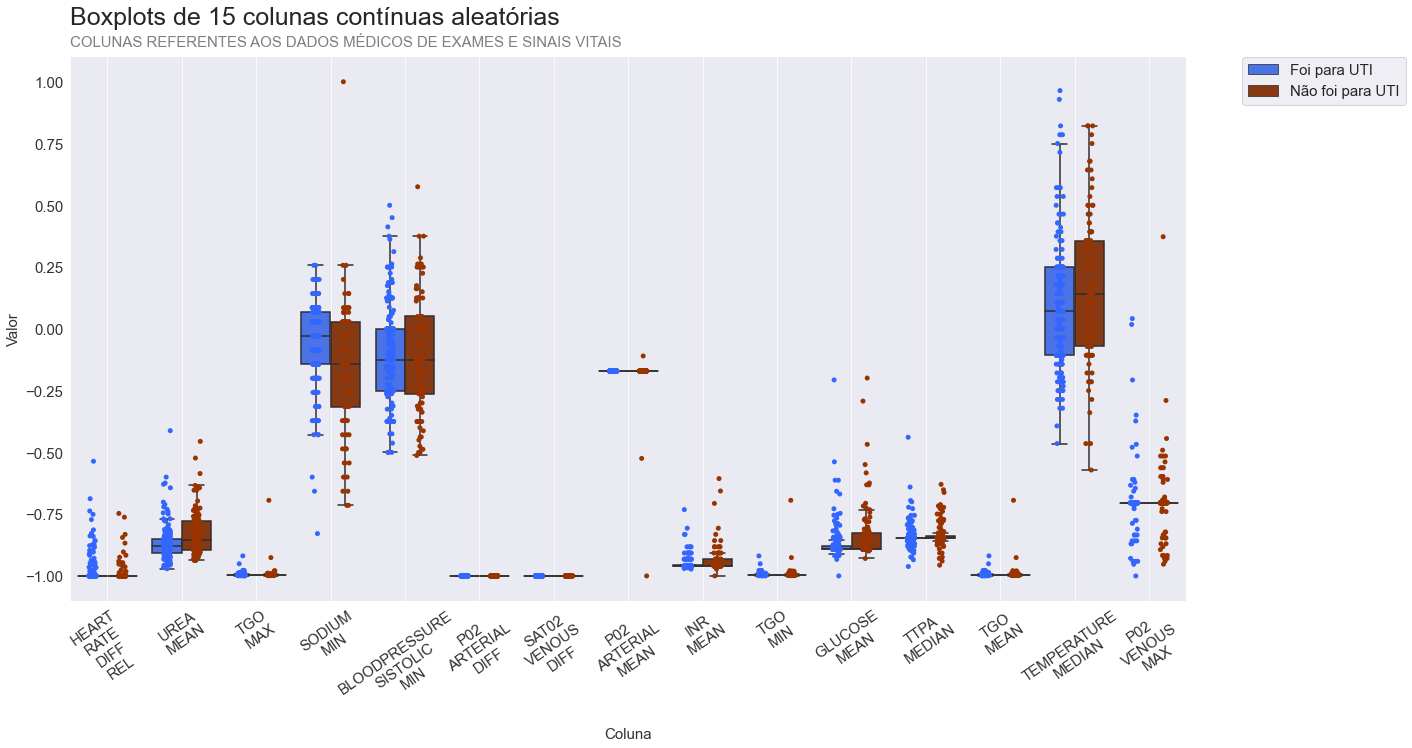

In [31]:
fig, ax = plt.subplots(figsize=(20,10))

sns.boxplot(x='variable', y='value', hue='ICU',
            data=cont_melt, palette=['#3366ff', '#993300'], 
            ax=ax, showfliers=False)
sns.stripplot(x='variable', y='value', hue='ICU',
              data=cont_melt, palette=['#3366ff', '#993300'],
              ax=ax, dodge=True)
labs(title='Boxplots de 15 colunas contínuas aleatórias', 
     xlabel='Coluna', 
     ylabel='Valor', 
     subtitle='COLUNAS REFERENTES AOS DADOS MÉDICOS DE EXAMES E SINAIS VITAIS', ax=ax)
plt.xticks(range(15),labels=cont_melt['variable'].str.split('_').str.join('\n').unique(), rotation=35)
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[0:2], ['Foi para UTI', 'Não foi para UTI'], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=15)
plt.show()

In [162]:
def binary_features(data:pd.DataFrame):
    '''
    Função que recebe um DataFrame do pandas e verifica quais as colunas binárias.Realiza essa verificação consultando quantos valores únicos a coluna possui
    e tenta transformar-la em números inteiros
    
    Parâmetros:
    -----------
    data : dataframe do pandas
    
    Retorno:
    --------
    features : colunas binárias do dataframe
    '''
    #Criando a lista vazia para armazenar as colunas binarias
    features = []
    
    #Percorrendo as colunas do dataframe
    for feature in data.columns:
        
        #Verificando se a coluna possui apenas 2 valores únicos
        if len(data[feature].unique()) == 2:
            
            try:
                #Tentando converter a coluna em números inteiros
                data[feature].astype('int64')
                
                #Salvando o nome da coluna na lista
                features.append(feature)
            except:
                #Se não conseguir converter para inteiro não é um coluna binária
                continue
                
    return features

In [163]:
binary_features(df)

['AGE_ABOVE65',
 'GENDER',
 'DISEASE GROUPING 1',
 'DISEASE GROUPING 2',
 'DISEASE GROUPING 3',
 'DISEASE GROUPING 4',
 'DISEASE GROUPING 5',
 'DISEASE GROUPING 6',
 'HTN',
 'IMMUNOCOMPROMISED',
 'OTHER',
 'ICU',
 'UNDER_30',
 '30th_40th',
 '50th_70th',
 'ABOVE_80']

In [155]:
df.to_csv('../dados/dados_preprocessados/Kaggle_Sirio_Libanes_ICU_Prediction.csv', index=False)